## Loading and Preprocessing Data

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [1]:
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Download latest version
path = kagglehub.dataset_download("rahulsah06/gooogle-stock-price")

print("Path to dataset files:", path)

C:\Users\artur\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\artur\.cache\kagglehub\datasets\rahulsah06\gooogle-stock-price\versions\1


In [2]:
# Importing the training set
dataset_train = pd.read_csv(path+"/Google_Stock_Price_Train.csv")

In [3]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
"Extracting only the Open price. Converting to a NumPy array. Shape becomes (number_of_days, 1)"
train = dataset_train.loc[:, ["Open"]].values
train

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]], shape=(1258, 1))

In [5]:
# Feature Scaling
"RNNs work better when inputs are in a small numerical range. Stock prices vary widely → scaling stabilizes training. Scales values to [0, 1]. "
"fit_transform learns min/max from training data and scales it"

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)
train_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]], shape=(1258, 1))

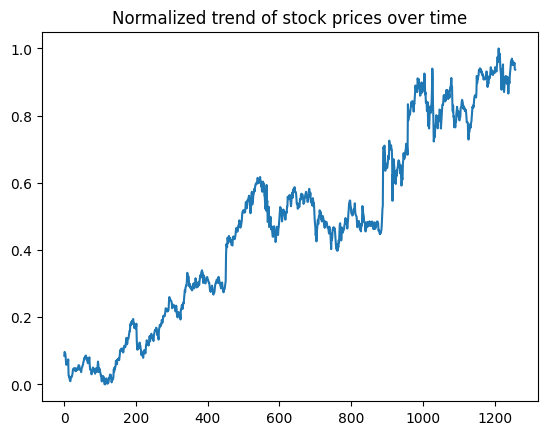

In [6]:
plt.plot(train_scaled)
plt.title("Normalized trend of stock prices over time")
plt.show()

In [ ]:
# Creating a data structure with 50 timesteps and 1 output
X_train = []
y_train = []
# timesteps = 50 # Each prediction uses the previous 50 days to predict the next day
timesteps = 65

for i in range(timesteps, 1258):
    X_train.append(train_scaled[i-timesteps:i, 0]) # sequences of 50 previous stock prices
    y_train.append(train_scaled[i, 0])             # the stock price immediately after those 50 days

X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
# Reshaping (for RNN input)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train # is in shape of (samples, timesteps, features) -> (number of training examples, 50, 1 feature=open price)

array([[[0.08581368],
        [0.09701243],
        [0.09433366],
        ...,
        [0.0418744 ],
        [0.04308356],
        [0.04877595]],

       [[0.09701243],
        [0.09433366],
        [0.09156187],
        ...,
        [0.04308356],
        [0.04877595],
        [0.04635762]],

       [[0.09433366],
        [0.09156187],
        [0.07984225],
        ...,
        [0.04877595],
        [0.04635762],
        [0.03748419]],

       ...,

       [[0.92246447],
        [0.91924622],
        [0.92335739],
        ...,
        [0.95475854],
        [0.95204256],
        [0.95163331]],

       [[0.91924622],
        [0.92335739],
        [0.91424213],
        ...,
        [0.95204256],
        [0.95163331],
        [0.95725128]],

       [[0.92335739],
        [0.91424213],
        [0.90758241],
        ...,
        [0.95163331],
        [0.95725128],
        [0.93796041]]], shape=(1168, 90, 1))

In [9]:
y_train

array([0.04635762, 0.03748419, 0.04170697, ..., 0.95725128, 0.93796041,
       0.93688146], shape=(1168,))

## Create RNN Model

In [10]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout


# Initialising the RNN
regressor = Sequential()

# 1st RNN layer with some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# 2nd RNN layer with some Dropout regularisation. Units = neurons. return_sequences needed as another RNN follows
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# 3rd RNN layer with some Dropout regularisation. Deep RNN structure improves pattern learning over time
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# A final 4th RNN layer with some Dropout regularisation. return_sequences is false as outputs only the last timestep
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Output layer - predicts next day's stock price
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 150, batch_size = 32)

Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.3230
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2021
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1421
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1189
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0986
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0784
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0670
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0532
Epoch 9/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0453
Epoch 10/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0389
Epoch 11/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0331
Epoch 12/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0324
Epoch 13/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0249
Epoch 14/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0243
Epoch 15/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - lo

## Predictions and Visualising RNN Model

In [11]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv(path+'/Google_Stock_Price_Test.csv')
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [12]:
# Ground truth for comparison
real_stock_price = dataset_test.loc[:, ["Open"]].values
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

In [13]:
# Getting the predicted stock price of 2017. 
"Predictions for day t need the previous 50 days. Some of those days come from training data"

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values.reshape(-1,1)
inputs = scaler.transform(inputs)  # min max scaler
inputs


array([[0.91424213],
       [0.90758241],
       [0.91130292],
       [0.91081926],
       [0.91191681],
       [0.90760101],
       [0.91176799],
       [0.91876256],
       [0.91958107],
       [0.93176576],
       [0.92914279],
       [0.91334921],
       [0.88550115],
       [0.90289456],
       [0.89383511],
       [0.89993675],
       [0.91269812],
       [0.917665  ],
       [0.91130292],
       [0.91811147],
       [0.93176576],
       [0.94402485],
       [0.93686286],
       [0.9233946 ],
       [0.9277662 ],
       [0.93444453],
       [0.92493861],
       [0.92106928],
       [0.92438053],
       [0.93048218],
       [0.9299055 ],
       [0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685],
       [0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.960

In [14]:
# Creates sliding windows just like training data. 70 corresponds to number of test days.
X_test = []
for i in range(timesteps, 70):
    X_test.append(inputs[i-timesteps:i, 0])

# Reshaped for RNN input. 
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)

# Predictions are scaled back to original price values
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


# Visualising the results -> how well the model follows the real trend?
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


IndexError: tuple index out of range

## Assignment
Try to improve the result! Document your actions and conclusions further in this notebook.

#### License
This Notebook has been released under the Apache 2.0 open source license.

https://www.kaggle.com/code/moonglow22/rnn-and-lstm-tutorial-for-beginners/notebook